# Text classification system that can automatically categorize customer complaints

In [240]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 7.5 MB/s eta 0:00:00


In [214]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import nltk, json
nltk.download('punkt')

import torch
from torch.utils.data import TensorDataset, DataLoader

import tensorflow as tf
import tensorflow_hub as hub

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Load and Prepare Data

In [215]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [261]:
with open('/content/drive/My Drive/code/Ticket/text.json', 'r') as f:
    text = json.load(f)

label = np.load('/content/drive/My Drive/code/Ticket/labels.npy')

In [262]:
df = pd.DataFrame({"text": text, "label": label})
df.head()

,text,label
0,"[i, called, because, i, have, been, receiving,...",2
1,"[this, call, took, place, at, around, noon, ,,...",2
2,"[i, am, a, victim, of, identity, theft, and, t...",2
3,"[conn, 's, calls, my, husband, 's, work, (, ),...",2
4,"[i, was, called, on, by, from, claiming, i, ha...",2


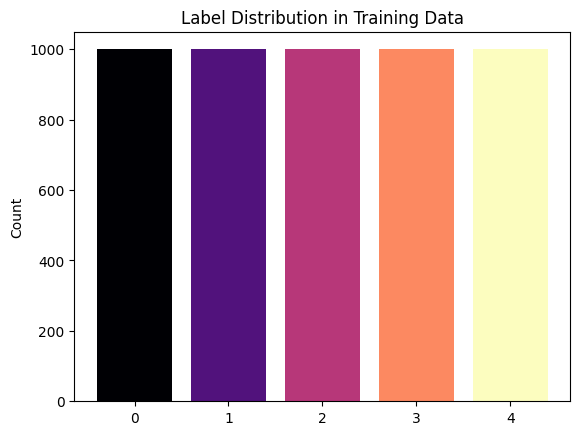

In [263]:
unique, counts = np.unique(label, return_counts=True)
label_count = dict(zip(unique, counts))

counts_array = np.array(list(label_count.values()))
ranks = np.argsort(np.argsort(counts_array))
colors = plt.cm.magma (ranks / max(ranks))

plt.bar(label_count.keys(), label_count.values(), color=colors)
plt.ylabel("Count")
plt.title("Label Distribution in Training Data")
plt.show()

#### Check for duplicates

In [264]:
from collections import Counter

sentence_counts = Counter(tuple(sentence) for sentence in text)
duplicates = {sentence: count for sentence, count in sentence_counts.items() if count > 1}

print("Duplicate Sentences:")
for sentence, count in duplicates.items():
    print(f"{list(sentence)} - {count} times")

Duplicate Sentences:
['i', 'am', 'a', 'victim', 'of', 'identity', 'theft', 'and', 'this', 'debt', 'does', 'not', 'belong', 'to', 'me', '.', 'please', 'see', 'the', 'identity', 'theft', 'report', 'and', 'legal', 'affidavit', 'attached', '.'] - 3 times
['i', 'was', 'shocked', 'when', 'i', 'reviewed', 'my', 'credit', 'report', 'this', 'week', 'and', 'i', 'found', 'multiple', 'inaccuracies', 'on', 'my', 'credit', 'report', 'from', 'the', '3', 'major', 'credit', 'bureaus', 'from', 'a', 'collection', 'company', 'that', 'i', 'never', 'have', 'dealt', 'with', 'before', '.', 'i', "'ve", 'attempted', 'several', 'times', 'to', 'ratify', 'the', 'issue', 'with', 'the', 'original', 'creditors', 'and', 'credit', 'bureaus', 'and', 'they', 'still', 'reporting', 'inaccurate', ',', 'unverifiable', 'information', '.', 'i', 'have', 'disputed', 'this', 'item', 'with', 'the', 'credit', 'reporting', 'agency', 'and', 'they', 'reported', 'you', 'confirmed', 'the', 'account', 'as', 'valid', '.', 'i', 'honestly',

#### Remove duplicate while keeping the first occurance

In [265]:
seen_sentences = set()
cleaned_text = []

for sentence, label in zip(text, label):
    sentence_tuple = tuple(sentence)
    if sentence_tuple not in seen_sentences:
        seen_sentences.add(sentence_tuple)
        cleaned_text.append((sentence, label))

In [266]:
import contractions

# that's -> that is
def expand_contractions(text):
    text = contractions.fix(text)
    return text

expanded_text = [
    ([expand_contractions(word) for word in sentence], label)
    for sentence, label in cleaned_text
]

In [267]:
text_data, label_data = zip(*expanded_text)
text_data = list(text_data)
label_data = list(label_data)

## Create vocab and index dictionary

In [268]:
word_counts = Counter(word for sentence in text_data for word in sentence)

# Sort words by frequency
vocab_list = [word for word, _ in word_counts.most_common()]

# Convert to dictionary with indices (starting from 2 for special tokens)
vocab = {"_PAD": 0, "_UNK": 1}
vocab.update({word: idx for idx, word in enumerate(vocab_list, start=2)})

print(list(vocab.items())[:10])

[('_PAD', 0), ('_UNK', 1), ('the', 2), ('.', 3), ('i', 4), ('to', 5), (',', 6), ('and', 7), ('a', 8), ('my', 9)]


In [269]:
vocab_size = len(vocab)
print(f'Vocab size: {vocab_size}')

Vocab size: 18235


#### Assign the index to the words based on created dictionary

In [270]:
for i, sentence in enumerate(text_data):
    text_data[i] = [vocab[word] if word in vocab else 0 for word in sentence]

#### Define a function that either shortens sentences or pads sentences with 0 to a fixed length

In [271]:
def pad_input(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

text_data = pad_input(text_data, 50)

## Create TensorFlow Dataset

In [272]:
train_text, test_text, train_label, test_label = train_test_split(text_data, label_data, test_size=0.3, random_state=42, shuffle=True)

In [273]:
train_val_dataset = tf.data.Dataset.from_tensor_slices((train_text, train_label))

train_ratio = 0.9
total_size = len(train_text)
train_size = int(train_ratio * total_size)

train_dataset = train_val_dataset.take(train_size)
val_dataset = train_val_dataset.skip(train_size)

train_dataset = train_dataset.map(lambda x, y: (tf.squeeze(x), y)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(lambda x, y: (tf.squeeze(x), y)).batch(1).prefetch(tf.data.AUTOTUNE)

In [274]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_text, test_label))
test_dataset = test_dataset.shuffle(len(test_text)).batch(1)

## Data Prediction
#### Initialize embedding layer

In [275]:
embedding_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
hub_layer = hub.KerasLayer(embedding_url, input_shape=[], dtype=tf.string, trainable=True)

In [276]:
from tensorflow.keras.layers import Layer

# Wrap hub.KerasLayer inside a Custom Layer
class HubEmbeddingLayer(Layer):
    def __init__(self, hub_layer):
        super(HubEmbeddingLayer, self).__init__()
        self.hub_layer = hub_layer

    def call(self, inputs):
        return self.hub_layer(inputs)

#### Initialize Model

In [277]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=50),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(5, activation="sigmoid")
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [278]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [279]:
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.2865 - loss: 1.5269 - val_accuracy: 0.5896 - val_loss: 1.1462
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.6693 - loss: 0.8869 - val_accuracy: 0.6705 - val_loss: 0.8239
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.8115 - loss: 0.5085 - val_accuracy: 0.7630 - val_loss: 0.7244
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.8814 - loss: 0.3561 - val_accuracy: 0.8150 - val_loss: 0.6471
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.9348 - loss: 0.2166 - val_accuracy: 0.8092 - val_loss: 0.7213
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.9520 - loss: 0.1819 - val_accuracy: 0.7399 - val_loss: 0.9783
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.9586 - loss: 0.1476 - val_accuracy: 0.7803 - val_loss: 0.8567
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.9774 - loss: 0.1021 - val_accuracy: 0.780

In [280]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (None, 50, 128)             │       2,334,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,151,441 (27.28 MB)

 Trainable params: 2,383,813 (9.09 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,767,628 (18.19 MB)

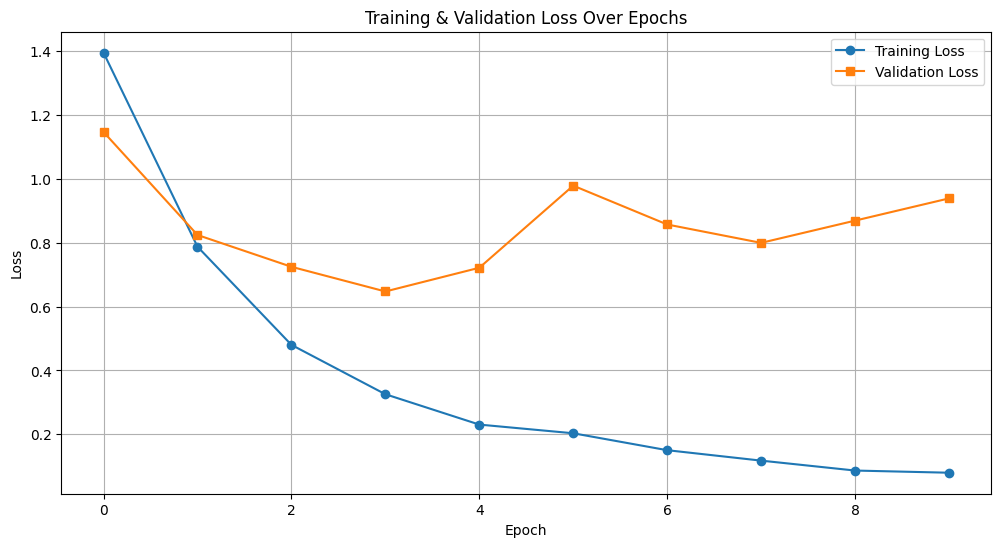

In [281]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.title('Training & Validation Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend()
plt.show()

#### Evaluation

In [282]:
test_loss, test_acc = model.evaluate(test_dataset, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

1483/1483 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7727 - loss: 0.9311
Test Loss: 1.0055
Test Accuracy: 0.7539


In [283]:
x_test, y_true = zip(*[data for data in test_dataset]) # Extract from dataset
x_test = np.squeeze(x_test)
x_test = np.array(x_test)
y_true = np.array(y_true)

y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1) # Convert to class labels

print(classification_report(y_true, y_pred))

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
              precision    recall  f1-score   support

           0       0.86      0.48      0.62       295
           1       0.64      0.76      0.69       315
           2       0.71      0.86      0.78       308
           3       0.81      0.80      0.80       278
           4       0.85      0.87      0.86       287

    accuracy                           0.75      1483
   macro avg       0.77      0.75      0.75      1483
weighted avg       0.77      0.75      0.75      1483



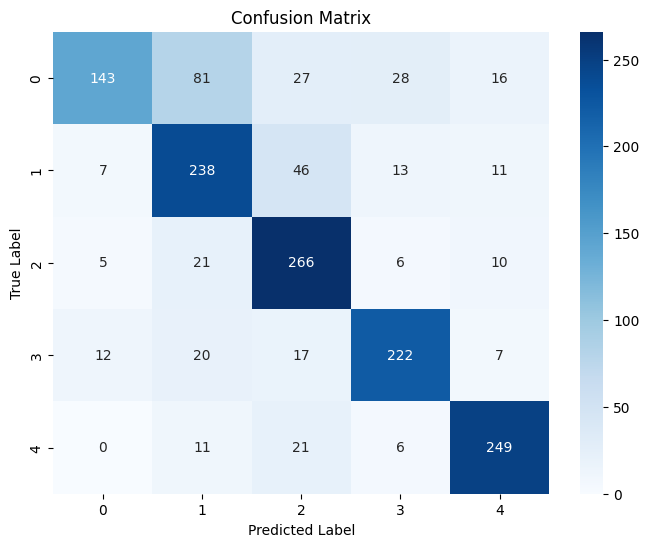

In [285]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()